In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, pdist, squareform
import pprint
import time

# Exercise 2

### Question 1

In [82]:
class undirected_chain():
    def __init__(self, psi, psi_2):
        """
        :param psi: list of array. The 1D array at position j corresponds to all possible values of log(psi_j),
        in the form of a vector
        :param psi_2: list of array. The 2D array at position j corresponds to all possible values of log(psi_j,j+1),
        in the form of a matrix
        
        Everything is saved on the log form
        """
        self.n = len(psi) # length of the chain
        self.psi = [np.log(v) for v in psi]
        self.psi_2 = [np.log(v) for v in psi_2]
        
        self.max_psi = [np.max(v) for v in self.psi]
        self.max_psi_2 = [np.max(v, axis=0) for v in self.psi_2]
        self.max_psi_2_rev = [np.max(v, axis=1) for v in self.psi_2] # used for beta
        
    def sum_product(self):
        """
        computes the forward and backward messages
        """
        # edge messages (alpha(0) and beta(n-1))
        self.alpha=[np.zeros(len(self.psi[0]))]
        self.beta=[np.zeros(len(self.psi[-1]))]
        
        # forward pass
        for j in range(self.n-1):
            term1 = self.max_psi[j] + self.max_psi_2[j] + np.max(self.alpha[-1])
            term2 = np.exp((self.psi[j]-self.max_psi[j])[:,None] + self.psi_2[j]-self.max_psi_2[j][None,:] + (self.alpha[-1]-np.max(self.alpha[-1]))[:,None])
            term = term1 + np.log(np.sum(term2, axis=0))
            self.alpha.append(term)
            
        # backward pass
        for j in range(self.n-2,-1,-1):
            term1 = self.max_psi[j+1] + self.max_psi_2_rev[j] + np.max(self.beta[-1])
            term2 = np.exp(self.psi[j+1]-self.max_psi[j+1] + self.psi_2[j]-self.max_psi_2_rev[j][:,None] + self.beta[-1]-np.max(self.beta[-1]))
            term = term1 + np.log(np.sum(term2, axis=1))
            self.beta.append(term)
            
    def normalize(self):
        """
        normalized the messages
        (unused)
        """
        self.alpha = [self.normalize_msg(alpha) for alpha in self.alpha]
        self.beta = [self.normalize_msg(beta) for beta in self.beta]
        
    def normalize_msg(self, msg):
        """
        normalized the messages
        (unused)
        """
        max_msg = np.max(msg)
        
        term1 = msg - max_msg
        term2 = np.exp(msg-max_msg)
        
        term = term1 - np.log(np.sum(term2))
        return term    
            
    def get_Z(self, j=-1, normalize=False):
        """
        computes Z directly
        :param j: node at which to compute Z
        :param normalize: whether to normalize messages
        """
        if not (self.alpha and self.beta):
            self.sum_product()
        if normalize:
            self.normalize()
        j = j%self.n
        Z = np.sum(np.exp(self.alpha[j] + self.psi[j] + self.beta[self.n-1-j]))
        return Z
    
    def get_log_Z(self, j=-1, normalize=False):
        """
        computes log(Z)
        :param j: node at which to compute Z
        :param normalize: whether to normalize messages
        """
        if not (self.alpha and self.beta):
            self.sum_product()
        if normalize:
            self.normalize()
        j = j%self.n
        term1 = np.max(self.alpha[j]) + self.max_psi[j] + np.max(self.beta[self.n-1-j])
        term2 = np.exp(self.alpha[j]-np.max(self.alpha[j]) + self.psi[j]-self.max_psi[j] + self.beta[self.n-1-j]-np.max(self.beta[self.n-1-j]))
        term = term1 + np.log(np.sum(term2))
        self.Z = term
        return self.Z
            
    def get_proba(self, j):
        """
        computes the probas at node j
        :param j: the node position
        """
        if not (self.alpha and self.beta):
            self.sum_product()
        if not self.Z:
            self.get_log_Z()
        j = j%self.n
        return np.exp(self.alpha[j] + self.psi[j] + self.beta[self.n-1-j] - self.Z)

In [83]:
# unit test

# initialize a small case
psi = [np.array([0.4, 0.6]), np.array([0.3, 0.7])]
psi_2 = [np.array([[0.1, 0.2],[0.3, 0.4]])]
ch = undirected_chain(psi, psi_2)
ch.sum_product()

# test on sum-product algorithm
print(np.allclose(ch.alpha[1], np.log(psi_2[0].T @ psi[0])))
print(np.allclose(ch.beta[1], np.log(psi_2[0] @ psi[1])))

# test on Z calculation
Z0 = (np.exp(ch.alpha[0])*np.exp(ch.beta[-1])) @ psi[0]
Z1 = (np.exp(ch.alpha[-1])*np.exp(ch.beta[0])) @ psi[1]

print(np.allclose(Z0, Z1))
print(np.allclose(Z0, ch.get_Z(0)))
print(np.allclose(Z0, ch.get_Z(-1)))

print(np.allclose(np.log(Z0), np.log(Z0)))
print(np.allclose(np.log(Z0), ch.get_log_Z(0)))
print(np.allclose(np.log(Z0), ch.get_log_Z(-1)))

True
True
True
True
True
True
True
True


In [84]:
# unit test

# initialize a small case (different number of values for nodes)
psi = [np.array([0.1, 0.4, 0.5]), np.array([0.3, 0.7])]
psi_2 = [np.array([[0.1, 0.2],[0.3, 0.4],[0.5, 0.6]])]
ch = undirected_chain(psi, psi_2)
ch.sum_product()

# test on sum-product algorithm
print(np.allclose(ch.alpha[1], np.log(psi_2[0].T @ psi[0])))
print(np.allclose(ch.beta[1], np.log(psi_2[0] @ psi[1])))

# test on Z calculation
Z0 = (np.exp(ch.alpha[0])*np.exp(ch.beta[-1])) @ psi[0]
Z1 = (np.exp(ch.alpha[-1])*np.exp(ch.beta[0])) @ psi[1]

print(np.allclose(Z0, Z1))
print(np.allclose(Z0, ch.get_Z(0)))
print(np.allclose(Z0, ch.get_Z(-1)))

print(np.allclose(np.log(Z0), np.log(Z0)))
print(np.allclose(np.log(Z0), ch.get_log_Z(0)))
print(np.allclose(np.log(Z0), ch.get_log_Z(-1)))

True
True
True
True
True
True
True
True


### Question 2

In [126]:
def ising_junction(beta, w=10, h=100):
    """
    For the Ising grid, returns the psi_j and psi_ij of the junction tree, in a suitable format to feed 
    the class undirected_chain and run the sum-product algorithm
    we assume alpha=0
    
    for psi_j, we have 2^w distinct values for (z_ij)j (in the form of a vector)
    for psi_ij, we have 2^w x 2^w distinct values for (z_ij)j x (z_ij)j (in the form of a matrix)
    
    the binary encoding of the index corresponds to the values of the z_ij of the row i
    """
    
    def nb_of_common_same_level(x):
        return (1-np.abs(np.diff(x, axis=1))).sum(axis=1)
    
    def nb_of_common_two_level(k1,k2):
        b1 = np.array([int(i) for i in list('{0:0b}'.format(k1).zfill(w))])
        b2 = np.array([int(i) for i in list('{0:0b}'.format(k2).zfill(w))])
        return nb_common_bits(b1,b2)
    
    def nb_common_bits(b1,b2):
        return (b1==b2).sum()
    
    def unpackbits(x,num_bits):
        xshape = list(x.shape)
        x = x.reshape([-1,1])
        to_and = 2**np.arange(num_bits).reshape([1,num_bits])
        return np.flip((x & to_and).astype(bool).astype(int).reshape(xshape + [num_bits]), axis=1)
        
    x = np.arange(2**w, dtype=np.uint32)
    y = unpackbits(x,w) # takes the binary encoding of each integer up to 2^w
    
    # nb of common values between two consecutive layers
    # calculates the number of common bits for two encodings and return the corresponding distance matrix
    dists = pdist(y, nb_common_bits) # for now, diagonal elements are 0
    different_layer = w * np.identity(2**w) + squareform(dists) # on the diagonal, we have w common bits (the whole row)
    
    # nb of equal consecutive values on the same layer
    same_layer = nb_of_common_same_level(y)
    
    # finally, compute psi and psi_2
    psi = [np.exp(beta*same_layer) for i in range(h)]
    psi_2 = [np.exp(beta*different_layer) for i in range(h-1)]
    
    return psi, psi_2

In [123]:
%%time
# computation for a small grid
psi, psi_2 = ising_junction(0, w=3, h=3)
ch = undirected_chain(psi, psi_2)
ch.sum_product()
Z = ch.get_log_Z(-1)
print(Z)

6.238324625039507
CPU times: user 2.55 ms, sys: 0 ns, total: 2.55 ms
Wall time: 2.17 ms


In [124]:
%%time
# computation for the grid of question 2
psi, psi_2 = ising_junction(0, w=10, h=100)
ch = undirected_chain(psi, psi_2)
ch.sum_product()
Z = ch.get_log_Z(-1)
print(Z)
# pprint.pprint(ch.alpha)

693.1471805599463
CPU times: user 7.43 s, sys: 1.37 s, total: 8.8 s
Wall time: 5.54 s


In [ ]:
# free RAM
ch = None

In [128]:
betas = np.concatenate((np.sort(-1*np.logspace(-3,2,6)), [0], np.logspace(-3,0,4)))
Zs = []
times = []

for beta in betas:
    start_time = time.time()
    print('Beta={}'.format(beta))
    psi, psi_2 = ising_junction(beta, w=10, h=100)
    ch = undirected_chain(psi, psi_2)
    ch.sum_product()
    Z = ch.get_log_Z(-1)
    end_time = time.time()
    total_time = end_time - start_time
    times.append(total_time)
    Zs.append(Z)
    print('Found log(Z)={}'.format(Z))
    print('Time ={}'.format(total_time))

Zs = np.array(Zs)
times = np.array(times)

Beta=-100.0


/home/henric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/henric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Found log(Z)=0.6931471805599453
Time =22.27475905418396
Beta=-10.0
Found log(Z)=0.6931471888251494
Time =4.651630401611328
Beta=-1.0
Found log(Z)=44.54243324777186
Time =4.49398136138916
Beta=-0.1
Found log(Z)=601.0142732271387
Time =4.449982643127441
Beta=-0.01
Found log(Z)=683.720806018391
Time =4.421876907348633
Beta=-0.001
Found log(Z)=692.2024168099916
Time =4.534369945526123
Beta=0.0
Found log(Z)=693.1471805599463
Time =4.493837356567383
Beta=0.001
Found log(Z)=694.0924168099921
Time =4.496837377548218
Beta=0.01
Found log(Z)=702.6208060183924
Time =4.450101613998413
Beta=0.1
Found log(Z)=790.0142732271373
Time =4.502776145935059
Beta=1.0
Found log(Z)=1934.542433247772
Time =4.561574935913086


In [131]:
# free RAM
ch = None

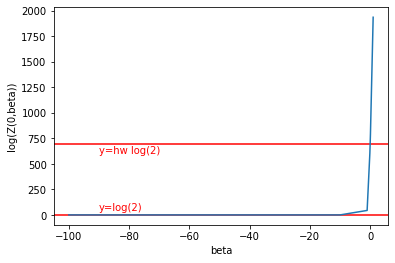

In [161]:
plt.axhline(np.log(2), color='red')
plt.axhline(100*10*np.log(2), color='red')

plt.text(-90, 50, 'y=log(2)', color='red')
plt.text(-90, 600, 'y=hw log(2)', color='red')

plt.plot(betas, Zs)
# plt.ylim(0,5)
plt.xlabel('beta')
plt.ylabel('log(Z(0,beta))')
# plt.savefig('pictures/exercise_2/junction_tree_Z_vs_beta.png')

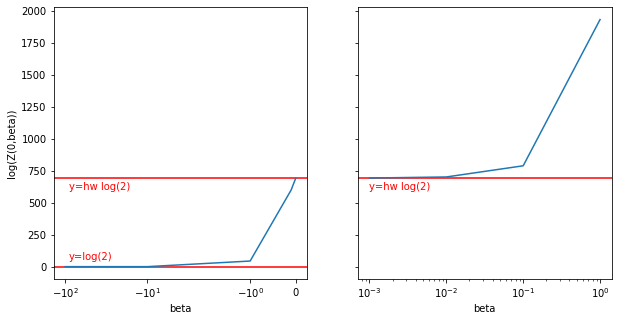

In [159]:
neg_betas_idx = np.where(betas<0)[0]
neg_betas = betas[neg_betas_idx]
neg_Zs = Zs[neg_betas_idx]

pos_betas_idx = np.where(betas>0)[0]
pos_betas = betas[pos_betas_idx]
pos_Zs = Zs[pos_betas_idx]

fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)

ax[0].set_xscale('symlog')
ax[1].set_xscale('log')

ax[0].set_ylabel('log(Z(0,beta))')
ax[0].set_xlabel('beta')
ax[1].set_xlabel('beta')

ax[0].axhline(np.log(2), color='red')
ax[0].axhline(100*10*np.log(2), color='red')
ax[1].axhline(100*10*np.log(2), color='red')

ax[0].text(-90, 50, 'y=log(2)', color='red')
ax[0].text(-90, 600, 'y=hw log(2)', color='red')
ax[1].text(0.001, 600, 'y=hw log(2)', color='red')

ax[0].plot(neg_betas, neg_Zs)
ax[1].plot(pos_betas, pos_Zs)

# plt.savefig('pictures/exercise_2/junction_tree_Z_vs_beta_logscale.png')

### Question 3

In [195]:
class Ising():
    def __init__(self, h, w, alpha, beta):
        """
        :param psi: list of array. The 1D array at position j corresponds to all possible values of log(psi_j),
        in the form of a vector
        :param psi_2: list of array. The 2D array at position j corresponds to all possible values of log(psi_j,j+1),
        in the form of a matrix

        Everything is saved on the log form
        """
        
        self.h = h
        self.w = w
        
        self.edges = []
        for i in range(h-1):
            for j in range(w):
                self.edges.append(((i,j),(i+1,j)))
        for i in range(h):
            for j in range(w-1):
                self.edges.append(((i,j),(i,j+1)))
        self.edges += [(v2,v1) for (v1,v2) in self.edges] # take reverse order too
        
        self.nb_edges = len(self.edges)
                
        self.psi = np.tile(alpha * np.arange(2), (h,w,1)) # work on the log, again
        self.psi_2 = {(v1,v2): beta*np.identity(2) for (v1,v2) in self.edges} # on the log
        
        self.max_psi = np.max(self.psi, axis=-1)
        self.max_psi_2 = {k:np.max(v, axis=1) for k,v in self.psi_2.items()}
        
        self.alpha = None
        self.Z = None
        
    def LBP(self, n, kind='naive', init='naive', normalize=True, verbose=False):
        """
        launches the loopy belief propagation algorithm
        
        :param n: number of iterations
        :param kind: way to do updates on iterations: naive for randomized updates,
        ordered to update messages in an ordered fashion
        tree to update messages along trees
        :param init: way to initialize messages. See init_alpha function
        :param normalize: whether to normalize messages
        :param verbose: print information
        """
        # initialization
        if not self.alpha:
            self.init_alpha()
            
        if normalize:
            self.normalizations={(v1,v2):np.zeros(2) for (v1,v2) in self.edges}
        
        # naive way
        if kind=='naive':
            for k in range(n):
                e = self.edges[np.random.randint(self.nb_edges)]
                self.update_msg(e, normalize=normalize, verbose=verbose)
                
        elif kind=='ordered':
            for k in range(n):
                for i in range(self.h):
                    for j in range(self.w):
                        edges = self.get_outcomine_edges((i,j))
                        e = edges[np.random.randint(len(edges))]
                self.update_msg(e, normalize=normalize, verbose=verbose)
                
        elif kind=='ordered2':
            for k in range(n):
                edges = np.random.shuffle(self.edges)
                for e in edges:
                    self.update_msg(e, normalize=normalize, verbose=verbose)
        
        elif kind=='tree':
            for k in range(n):
                # extract a tree from the graph
                tree = self.extract_tree()
                for e in tree:
                    self.update_msg(e, normalize=normalize, verbose=verbose)
                for (v1,v2) in reversed(tree):
                    self.update_msg((v2,v1), normalize=normalize, verbose=verbose)
        else:
            raise(ValueError)
            
    def init_alpha(self, kind='naive'):
        """
        initializes the messages
        naive: messages equal to 1
        random: take random values on a standard normal distribution
        """
        print('Initialize alpha')
        
        if kind == 'naive':
            self.alpha={(v1,v2):np.zeros(2) for (v1,v2) in self.edges}
        elif kind == 'random':
            self.alpha={(v1,v2):np.random.normal(size=2) for (v1,v2) in self.edges}
        else:
            raise(ValueError)
    
    def extract_tree(self):
        """
        extract a random tree of maximum length from the grid
        """
        (i,j) = np.random.randint(self.h), np.random.randint(self.w)
        v = (i,j)
        taken = [v]
        
        while True:
            children = self.get_outcoming_edges(v)
            children_vertices = [child[1] for child in children] # take all vertices
            children_vertices = list(set(children_vertices).difference(set(taken)))
            if children_vertices == []:
                break
            child_vertex = children_vertices[np.random.randint(len(children_vertices))]
            taken.append(child_vertex)
            v = child_vertex
        return [(taken[i],taken[i+1]) for i in range(len(taken)-1)]
        
    def get_children(self, e):
        """
        lists all the edges following the edge e
        :param e: an edge
        """
        (v1,v2) = e
        return [(s1,s2) for (s1,s2) in self.edges if s1==v2 and s2!=v1]
    
    def get_parents(self, e):
        """
        lists all the edges preceding the edge e
        :param e: an edge
        """
        (v1,v2) = e
        return [(s1,s2) for (s1,s2) in self.edges if s2==v1 and s1!=v2]
    
    def get_incoming_edges(self, v):
        """
        lists all the edges going to the node v
        :param v: a node
        """
        return [(s1,s2) for (s1,s2) in self.edges if s2==v]
    
    def get_outcoming_edges(self, v):
        """
        lists all the edges leaving the node v
        :param v: a node
        """
        return [(s1,s2) for (s1,s2) in self.edges if s1==v]
    
    def update_msg(self, e1, normalize=True, verbose=False):
        """
        calculates and updates the message of the edge e1
        :param normalize: whether to normalize the message
        :param verbose: print information
        """
        (v1,v2) = e1
        neighbors = self.get_parents(e1)
        max_msgs = np.zeros(2)
        for e2 in neighbors:
            max_msgs += np.max(self.alpha[e2])
        term1 = self.max_psi[v1] + self.max_psi_2[(v1,v2)] + max_msgs

        msgs = np.zeros(2)
        for e2 in neighbors:
            msgs += self.alpha[e2]
        term2 = np.exp((self.psi[v1]-self.max_psi[v1])[:,None] + self.psi_2[(v1,v2)]-self.max_psi_2[(v1,v2)][None,:] + (msgs-max_msgs)[:,None])
        
        if verbose:
            print('msg : {}'.format(msgs))
#             print(term1)
#             print(term2)
        term = term1 + np.log(np.sum(term2, axis=0))
        if verbose:
            print('unormalized : {}'.format(term))
        if normalize:
            new_term = self.normalize_msg(term) # we normalize msgs
            self.normalizations[e1] += new_term - term # keep track of normalizations
            term = new_term
        if verbose:
            print('normalized : {}'.format(term))
        
        self.alpha[(v1,v2)] = term 
    
    def normalize_msg(self, msg):
        """
        normalizes a message
        :param msg: the message
        """
        max_msg = np.max(msg)
        
        term1 = msg - max_msg
        term2 = np.exp(msg-max_msg)
        
        term = term1 - np.log(np.sum(term2))
        return term      
                      
    def get_Z(self, v=(0,0)):
        """
        computes Z directly
        :param j: node at which to compute Z
        :param normalize: whether to normalize messages
        """
        if not self.alpha:
            self.LBP()
        
        (i,j) = v
        i = i%self.h
        j = j%self.w
        v = (i,j)
        
        neighbors = self.get_incoming_edges(v)
        msgs = 0
        for e in neighbors:
            msgs += self.alpha[e]
        
        Z = np.sum(np.exp(self.psi[(i,j)] + msgs))
        return Z
    
    def get_log_Z(self, v=(0,0)):
        """
        computes log(Z)
        :param j: node at which to compute Z
        :param normalize: whether to normalize messages
        """
        if not self.alpha:
            self.LBP()
            
        (i,j) = v
        i = i%self.h
        j = j%self.w
        v = (i,j)
        
        neighbors = self.get_incoming_edges(v)
        max_msgs = 0
        for e in neighbors:
            max_msgs += np.max(self.alpha[e])
        term1 = self.max_psi[i,j] + max_msgs

        msgs = np.zeros(2)
        for e in neighbors:
            msgs += self.alpha[e]
        term2 = np.exp((self.psi[i,j]-self.max_psi[i,j])[:,None] + (msgs-max_msgs)[:,None])
        term = term1 + np.log(np.sum(term2))
        self.Z = term
        return term
            
    def get_proba(self, v=(0,0)):
        """
        computes the probabilities for a node v
        for security, we normalize at the end (not necessary, theoretically)
        :param v: the node
        """
        if not self.alpha:
            self.LBP(500)
        
        self.get_log_Z(v)
            
        (i,j) = v
        i = i%self.h
        j = j%self.w
        v = (i,j)
        
        neighbors = self.get_incoming_edges(v)
        msgs = np.zeros(2)
        for e in neighbors:
            msgs += self.alpha[e]
        
        probas = np.exp(self.psi[i,j] + msgs - self.Z)
        return probas / np.sum(probas)
    
    def get_unnormed_proba(self, v=(0,0)):
        """
        computes the probabilities for a node v
        we do not normalize at the end (not necessary, theoretically)
        :param v: the node
        """
        if not self.alpha:
            self.LBP()
        
        self.get_log_Z(v)
            
        (i,j) = v
        i = i%self.h
        j = j%self.w
        v = (i,j)
        
        neighbors = self.get_incoming_edges(v)
        msgs = np.zeros(2)
        for e in neighbors:
            msgs += self.alpha[e]
        
        probas = np.exp(self.psi[i,j] + msgs - self.Z)
        return probas
    
    def get_couple_proba(self, v1, v2):
        """
        returns the joint probabilities for a couple of adjacent vertices
        """
        if not self.alpha:
            self.LBP()
        if not self.Z:
            self.get_log_Z()
        if (v1,v2) not in self.edges:
            raise(ValueError)
            
        parents_1 = self.get_incoming_edges(v1)
        parents_2 = self.get_incoming_edges(v2)
        
        sum_1 = np.zeros(2)
        for e in parents_1:
            sum_1 += self.alpha[e]
        
        sum_2 = np.zeros(2)
        for e in parents_2:
            sum_2 += self.alpha[e]
            
        probas = np.exp(self.psi[v1][None,:] + self.psi[v2][:,None] + self.psi_2[(v1,v2)] + sum_1[None,:] + sum_2[:,None] - self.Z)
        
        return probas / np.sum(probas)
    
#     def get_probas(self, v_list):
#         edges = [(v1,v2) for i,v1 in enumerate(v_list[:-1]) for v2 in v_list[i+1:]]
#         if edges == []:
#             return get_proba
#         for e in edges:
#             if e not in self.edges:
#                 raise(ValueError)
#         e = edges[0]
#         sum_psi = np.outer(self.psi[v_list[0]], self.psi[v_list[1]]) * self.psi_2[(v_list[0], v_list[1])]
#         old_v = v_list[1]
#         for v in v_list[2:]:
#             sum_psi = np.multiply.outer(sum_psi, self.psi[v]) * self.psi_2[(old_v, v)]
#             old_v = v
    
    def check_msg(self):
        """
        after convergence, check if contrary messages have the same values
        """
        comp = {}
        i = 0
        for (v1,v2) in self.edges:
            if v1<=v2:
                comp[(v1,v2)] = self.alpha[(v1,v2)]-self.alpha[(v2,v1)]
        pprint.pprint(comp)

In [217]:
# unit test on a small case
h,w = 3,3
ising = Ising(h=h,w=w,alpha=0,beta=0)
ising.LBP(500, 'tree')
log_Z = ising.get_log_Z()

# proba does not need to be normalized test
print(np.allclose(ising.get_proba((0,0)),ising.get_unnormed_proba((0,0))))
print(np.allclose(ising.get_proba((1,1)),ising.get_unnormed_proba((1,1))))
print(np.allclose(ising.get_proba((2,1)),ising.get_unnormed_proba((2,1))))
print(np.allclose(ising.get_proba((3,3)),ising.get_unnormed_proba((3,3))))

# normalization test
msg = np.exp(np.array([1,2]))
log_msg = np.log(msg)

norm_msg = msg/np.sum(msg)
norm_log_msg = np.log(norm_msg)

np.allclose(norm_log_msg, ising.normalize_msg(log_msg))

# couple probability test
print((ising.get_couple_proba((0,1),(0,0)) == ising.get_couple_proba((0,0),(0,1)).T).all())

# check value of Z with expected value: wee see a difference (see report for explanations)
print('calculated value for log(Z) = {}'.format(log_Z))
print('expected value for log(Z) = {}'.format(h*w*np.log(2)))

Initialize alpha
True
True
True
True
True
calculated value for log(Z) = -0.6931471805599453
expected value for log(Z) = 6.238324625039508


In [218]:
# without normalization, we run into trouble for convergence

ising = Ising(h=100,w=10,alpha=0,beta=-1)
ising.init_alpha('random')
ising.LBP(500, 'tree', normalize=False, verbose=False)

print(ising.get_log_Z())
print(ising.get_couple_proba((0,1),(0,0)))

Initialize alpha
1.3153171154558166e+98
[[nan nan]
 [nan nan]]


/home/henric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:316: RuntimeWarning: overflow encountered in exp
/home/henric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:318: RuntimeWarning: invalid value encountered in true_divide


In [219]:
# same with normalization
ising = Ising(h=100,w=10,alpha=0,beta=-1)
ising.init_alpha('random')
ising.LBP(2000, 'tree', normalize=True, verbose=False)

print(ising.get_log_Z())
print(ising.get_couple_proba((0,1),(0,0)))

Initialize alpha
-0.6309926145365957
[[0.06545631 0.77069826]
 [0.06317614 0.10066929]]


In [223]:
# the values for log(Z_j) are different, depending on the node we take, because of the normalization
print(ising.get_log_Z((0,0)))
print(ising.get_log_Z((1,1)))
print(ising.get_log_Z((1,2)))
print(ising.get_log_Z((2,2)))

-0.6309926145365957
-1.7496145555431297
-1.639709636901878
-1.5169662836823103


In [231]:
# the ratio Z_j / prod alpha_kj could help to find Z
neighbors = ising.get_incoming_edges((0,0))
msg = np.zeros(2)
for e in neighbors:
    msg += ising.alpha[e]
    
print(ising.get_log_Z((0,0)) - msg)

neighbors = ising.get_incoming_edges((1,2))
msg = np.zeros(2)
for e in neighbors:
    msg += ising.alpha[e]
    
print(ising.get_log_Z((1,2)) - msg)

[0.30384897 1.33930512]
[2.5986523  0.07728474]
